# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [2]:
! git clone https://github.com/ds4e/linearModels

Cloning into 'linearModels'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 43 (delta 9), reused 5 (delta 5), pack-reused 27 (from 1)
Receiving objects: 100% (43/43), 3.60 MiB | 4.49 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [3]:
# 1

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv('/content/linearModels/lab/data/pierce_county_house_sales.csv')

In [4]:
# Find which columns have substantial missing values
missing_values = df.isnull().sum()
print(missing_values)

sale_date                          0
sale_price                         0
house_square_feet                  0
attic_finished_square_feet         0
basement_square_feet               0
attached_garage_square_feet        0
detached_garage_square_feet        0
fireplaces                         0
hvac_description                   7
exterior                           1
interior                           7
stories                            0
roof_cover                         8
year_built                         0
bedrooms                           0
bathrooms                          0
waterfront_type                16261
view_quality                   15895
utility_sewer                      0
dtype: int64


In [5]:
# Drop columns with many missing values
df_clean = df.drop(columns=['waterfront_type', 'view_quality'])

# Fill small number of missing values with mode
for col in ['exterior', 'interior', 'roof_cover']:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

df_clean['sale_date'] = pd.to_datetime(df_clean['sale_date'], format='%Y-%m-%d')

# Making new columns
df_clean['sale_year'] = df_clean['sale_date'].dt.year
df_clean['age'] = df_clean['sale_year'] - df_clean['year_built']

print(df_clean.head())
print("\nSummary statistics:")
print(df_clean[['sale_price', 'house_square_feet', 'bedrooms', 'bathrooms', 'age']].describe())

   sale_date  sale_price  house_square_feet  attic_finished_square_feet  \
0 2020-01-02      380000               2157                           0   
1 2020-01-02      383000               2238                           0   
2 2020-01-01      419900               1452                           0   
3 2020-01-02      251660                832                           0   
4 2020-01-02      500000               1780                           0   

   basement_square_feet  attached_garage_square_feet  \
0                     0                          528   
1                     0                          396   
2                     0                            0   
3                     0                            0   
4                   384                          484   

   detached_garage_square_feet  fireplaces        hvac_description  \
0                            0           0  Warm and Cool Air Zone   
1                            0           0              Forced Air   
2 

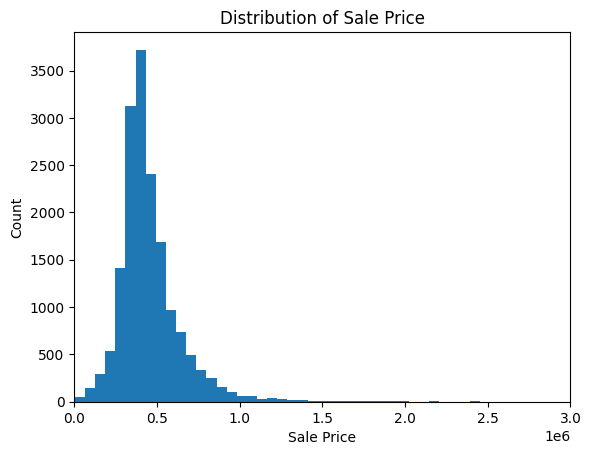

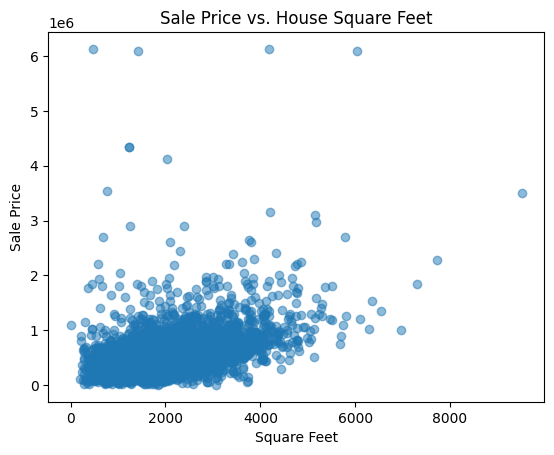

<Figure size 640x480 with 0 Axes>

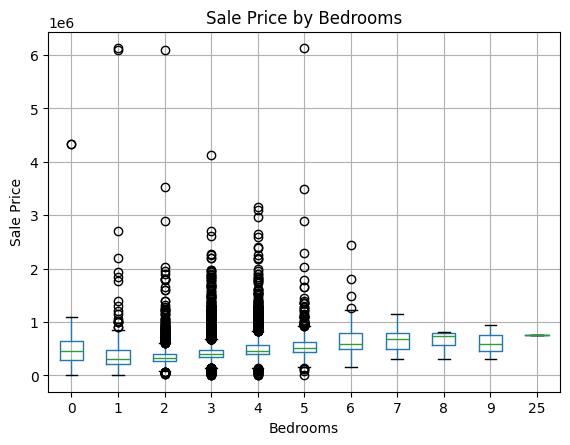

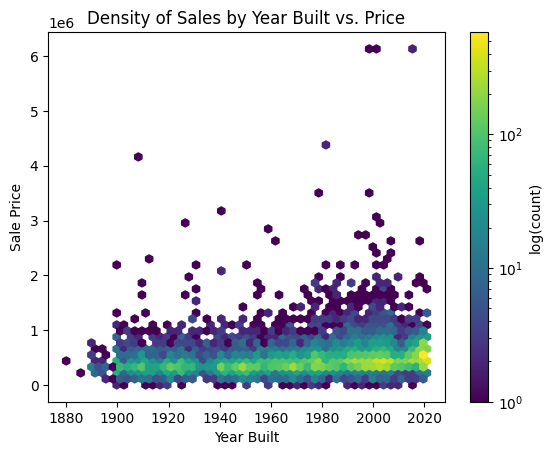

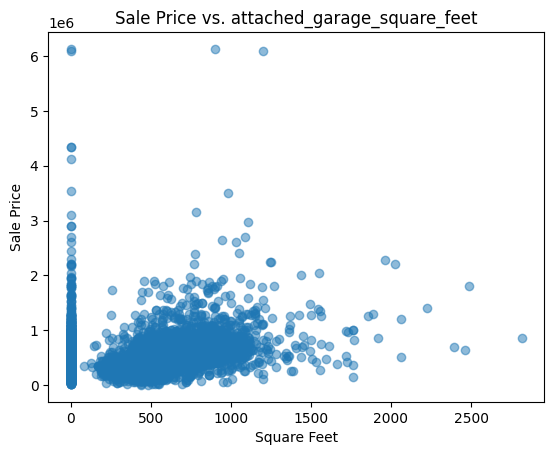

In [32]:
# Distribution of Sale Price
plt.figure()
plt.hist(df_clean['sale_price'], bins=100)
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.xlim(0, 3000000)
plt.show()

# Sale Price vs. House Square Feet
plt.figure()
plt.scatter(df_clean['house_square_feet'], df_clean['sale_price'], alpha=0.5)
plt.title('Sale Price vs. House Square Feet')
plt.xlabel('Square Feet')
plt.ylabel('Sale Price')
plt.show()

# Sale Price by Number of Bedrooms
plt.figure()
df_clean.boxplot(column='sale_price', by='bedrooms')
plt.title('Sale Price by Bedrooms')
plt.suptitle('')
plt.xlabel('Bedrooms')
plt.ylabel('Sale Price')
plt.show()

# Sale Price vs. Year Built
plt.figure()
plt.hexbin(
    df['year_built'],
    df['sale_price'],
    gridsize=50,
    bins='log',
    mincnt=1
)
plt.title('Density of Sales by Year Built vs. Price')
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.colorbar(label='log(count)')
plt.show()

In [24]:
# 2

y = df_clean['sale_price']
X = df_clean.drop(columns=['sale_price', 'sale_date'])

# One-hot encode categoricals
cat_cols = ['hvac_description', 'exterior', 'interior', 'roof_cover', 'utility_sewer',
            'fireplaces', 'bedrooms', 'bathrooms']
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 3

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.20, random_state=102402)

In [25]:
# 4

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

models = {
    'SqFt':       ['house_square_feet'],
    'Age':        ['age'],
    'All_Numeric': [
        'house_square_feet', 'attic_finished_square_feet', 'basement_square_feet',
        'attached_garage_square_feet', 'detached_garage_square_feet', 'age'
    ]
}

results = []
for name, feats in models.items():
    lr = LinearRegression().fit(X_train[feats], y_train)
    for split, Xs, ys in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
        preds = lr.predict(Xs[feats])
        results.append({
            'Model': name,
            'Split': split,
            'RMSE': np.sqrt(mean_squared_error(ys, preds)),
            'R2':   r2_score(ys, preds)
        })

# Full model with all predictors
lr_full = LinearRegression().fit(X_train, y_train)
for split, Xs, ys in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
    preds = lr_full.predict(Xs)
    results.append({
        'Model': 'Full',
        'Split': split,
        'RMSE': np.sqrt(mean_squared_error(ys, preds)),
        'R2':   r2_score(ys, preds)
    })

# Display comparison
results_df = pd.DataFrame(results)
pivoted = results_df.pivot(index='Model', columns='Split')
print(results_df)

         Model  Split           RMSE        R2
0         SqFt  Train  196157.544673  0.285612
1         SqFt   Test  218073.310233  0.247707
2          Age  Train  225857.306234  0.052907
3          Age   Test  244983.304201  0.050587
4  All_Numeric  Train  183679.137432  0.373611
5  All_Numeric   Test  203458.769811  0.345160
6         Full  Train  171841.949733  0.451745
7         Full   Test  194405.355027  0.402141


The best performing models seem to be the ones that utilize the most amount of data (i.e All_Numeric and Full). They have the lowest RMSE and and highest R^2 of 0.345 and 0.402 respectively.

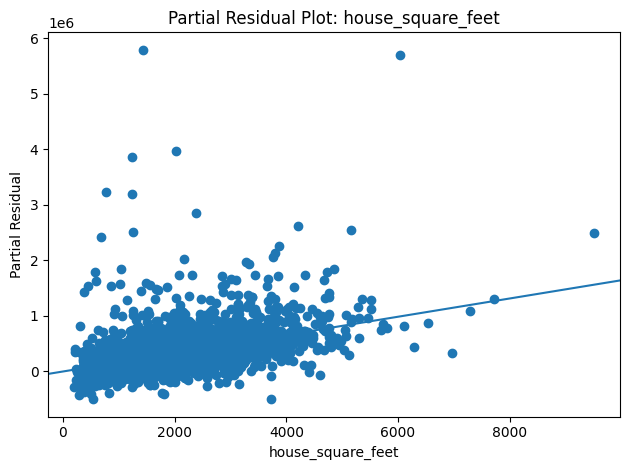

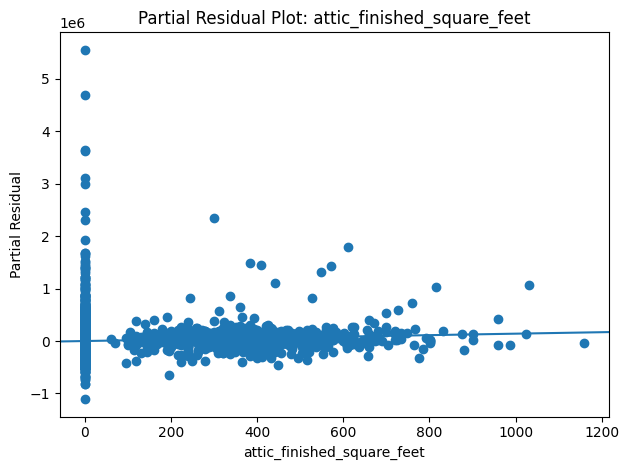

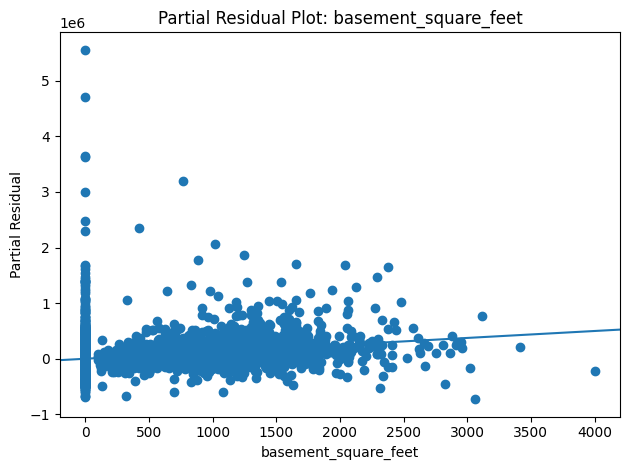

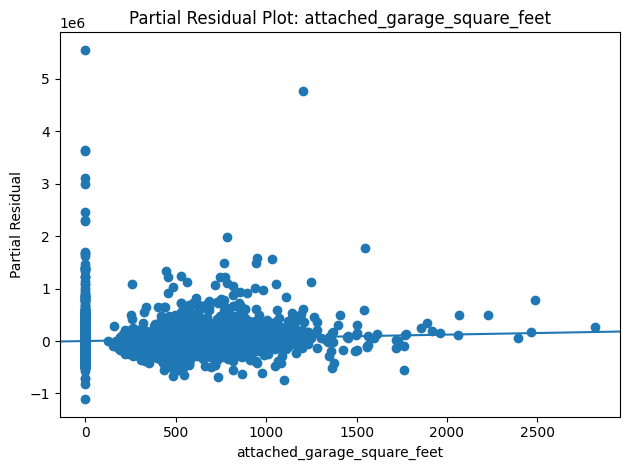

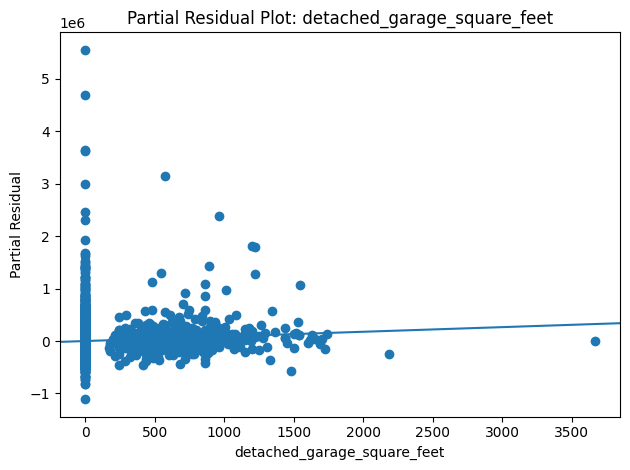

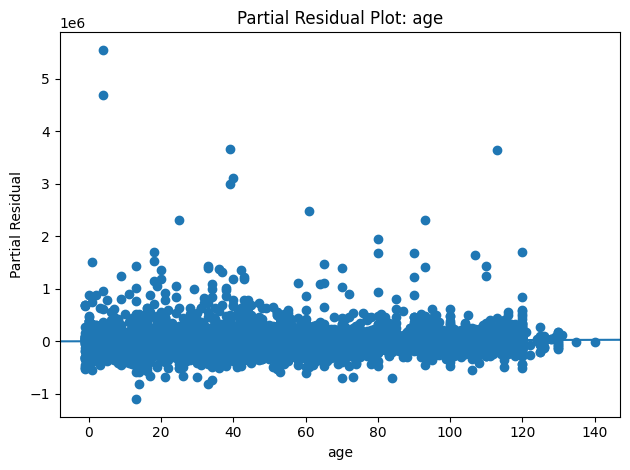

In [26]:
# 5

import statsmodels.api as sm

X_train = X_train.astype(float)
ols_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

numeric_vars = [
    'house_square_feet',
    'attic_finished_square_feet',
    'basement_square_feet',
    'attached_garage_square_feet',
    'detached_garage_square_feet',
    'age'
]
# loop through numeric vars and plot partial-residual plots
for var in numeric_vars:
    fig, ax = plt.subplots()
    sm.graphics.plot_ccpr(ols_model, var, ax=ax)
    ax.set_title(f'Partial Residual Plot: {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Partial Residual')
    plt.tight_layout()
    plt.show()

Significant non-linearities I noticed were in the discrete variables—fireplaces, bedrooms, bathrooms.

In [39]:
# 5

df_clean['has_basement'] = (df_clean['basement_square_feet'] > 0).astype(int)
df_clean['has_attached_garage'] = (df_clean['attached_garage_square_feet'] > 0).astype(int)
df_clean['has_detached_garage'] = (df_clean['detached_garage_square_feet'] > 0).astype(int)

df_clean['log_basement_sqft'] = np.log1p(df_clean['basement_square_feet'])
df_clean['log_attached_garage_sqft'] = np.log1p(df_clean['attached_garage_square_feet'])
df_clean['log_detached_garage_sqft'] = np.log1p(df_clean['detached_garage_square_feet'])

cat_cols = ['hvac_description', 'exterior', 'interior', 'roof_cover', 'utility_sewer',
            'fireplaces', 'bedrooms', 'bathrooms', 'has_basement', 'has_attached_garage',
            'has_detached_garage']

X = df_clean.drop(columns=['sale_price', 'sale_date'])
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.20, random_state=102402)

lr = LinearRegression().fit(X_train, y_train)
metrics = []
for split, Xs, ys in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
    preds = lr.predict(Xs)
    metrics.append({
        'Split': split,
        'RMSE': np.sqrt(mean_squared_error(ys, preds)),
        'R2': r2_score(ys, preds)
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

   Split           RMSE        R2
0  Train  170978.856840  0.457238
1   Test  193718.964277  0.406355


There is marginal improvement from the non transformed model compared to the transformed model. Only increasing the R^2 by about 0.004 and decreasing the RMSE by around 7000, which is very little in this context.

# 6

Over the six steps, I began by visually exploring sale price against core predictors—square footage, room counts, and age—to uncover strong positive trends, right‐skewed prices, and discrete jumps for each extra bedroom or bathroom. The first linear trials (e.g. a single‐feature model on square footage explaining roughly 25–29% of price variance, and an “all numeric” specification reaching about 35–37% R^2) clearly underfit the data. Introducing one‐hot categories for rooms and all remaining features (“full” model) boosted explained variance to around 40 % out‐of‐sample and cut RMSE by nearly $25 k. Partial‐residual plots then revealed non‐linear patterns—diminishing returns on large floor areas, rapid early depreciation in age, and step-effects in room counts—so we engineered two-part features for basements and garages (binary “has_” flags plus log-size). This more nuanced model nudged test R^2 up a few points (from 0.402 to about 0.406) and further trimmed RMSE. Through this process, we saw classic underfitting in our simplest regressions and some overfitting in the training data having better RMSE and R^2 values.